# Normalizacja tekstu

In [26]:
import pandas as pd

In [27]:
df = pd.read_csv("reviews_eda1.csv")

In [28]:
df.columns

Index(['Unnamed: 0', 'Link', 'Autor', 'Tytuł', 'Data_recenzji',
       'Treść_recenzji', 'Średnia_ocen', 'Liczba_ocen', 'Liczba_czytelników',
       'Rok_recenzji'],
      dtype='object')

In [ ]:
# Sprawdzam język treści - służy do tego biblioteka langdetect, funkcja detect wykrywa języka tekstu na podstawie zawartości tekstu.

In [29]:
from langdetect import detect

In [30]:
df["language_reviews"] = df["Treść_recenzji"].apply(detect)

In [31]:
df["language_reviews"].value_counts()

language_reviews
pl    5962
Name: count, dtype: int64

In [ ]:
# Jak widać powyżej, wszystkie recenzje są w języku polskim.
# Kolejny krok to tokenizacja.
# Będę korzystała z biblioteki spaCy (wcześniej zrobiłam w nltk, ale spaCy jest lepsza dla PL).

In [ ]:
#!python -m spacy download pl_core_news_lg

In [32]:
import spacy

In [33]:
nlp = spacy.load("pl_core_news_lg")

In [34]:
from spacy.lang.pl.stop_words import STOP_WORDS

In [35]:
print(STOP_WORDS)

{'powieści', 'zł', 'został', 'też', 'jestesmy', 'jeszcze', 'innych', 'one', 'żeby', 'jakichś', 'dwaj', 'autorke', 'tutaj', 'było', 'tego', 'niż', 'bede', 'bylo', 'xiii', 'kiedy', 'on', 'kazda', 'ktore', 'kto', 'tę', 'wasze', 'powiesci', 'był', 'ksiazki', 'pisarka', 'ci', 'jakichs', 'jeżeli', 'pisarzem', 'sama', 'czytelnikiem', 'można', 'wy', 'lat', 'bedzie', 'jeśli', 'wasz', 'nasza', 'naszych', 'kilka', 'ksiazka', 'niech', 'autorka', 'taki', 'temu', 'przy', 'gdy', 'moga', 'nas', 'wszystko', 'które', 'aj', 'bardzo', 'moze', 'powiescią', 'ku', 'postacią', 'mozna', 'natychmiast', 'nich', 'jesteśmy', 'około', 'od', 'cali', 'według', 'ksiązce', 'wszystkiemu', 'byl', 'acz', 'teraz', 'zadna', 'twoja', 'właśnie', 'razie', 'powinni', 'oto', 'że', 'bohaterów', 'niz', 'lekturą', 'gdyby', 'toteż', 'wie', 'totez', 'zeznowu', 'czyli', 'swoje', 'więcej', 'jeden', 'to', 'xi', 'nią', 'juz', 'mu', 'jedno', 'przede', 'zl', 'będę', 'tys', 'dużo', 'byly', 'iż', 'znów', 'owszem', 'ktorą', 'ksiazką', 'powieś

### W związku z tym, że postanowiłma nieco dopasować stopwords na potrzeby tego projektu, musiałam zmodyfikowac listę stopwords, którą proponuje spacy.

In [36]:
# Pobieram stopwords z wcześniej przygotowanego pliku .txt
with open("polish_reviews_books.txt", "r", encoding="utf-8") as file:
    stopwords_polish = file.read().splitlines()

In [ ]:
stopwords_to_remove = ["nie", "bez"] # potrzebuję te słowa
stopwords_to_add = stopwords_polish

for stopword in stopwords_to_remove:
    if stopword in STOP_WORDS:
        STOP_WORDS.remove(stopword)
        print(f"Słowo '{stopword}' zostało usunięte z listy STOP_WORDS.")
    else:
        print(f"Słowo '{stopword}' nie było obecne na liście STOP_WORDS.")

for stopword in stopwords_to_add:
    if stopword in STOP_WORDS:
        print(f"Słowo '{stopword}' jest już na liście STOP_WORDS.")
    else:
        STOP_WORDS.add(stopword)
        print(f"Słowo '{stopword}' zostało dodane do listy STOP_WORDS.")

print(f"Zaktualizowana lista STOP_WORDS: '{STOP_WORDS}'.")

In [40]:
def tokenize(text):
    doc = nlp(text)
    tokens = []
    for i, token in enumerate(doc):
        if token.is_alpha and token.lemma_.lower() not in nlp.Defaults.stop_words:
            if token.lemma_.lower() in {"nie", "bez"} and i < len(doc) - 1:
                tokens.append(f"{token.lemma_.lower()}_{doc[i+1].lemma_.lower()}")
            else:
                tokens.append(token.lemma_.lower())
    return tokens

In [41]:
# Robię tokenizację dla kolumny "Treść_recenzji"
df["tokenized_reviews"] = df["Treść_recenzji"].apply(tokenize)

In [42]:
# To będzie moja wyjściowa ramka danych do dalszych prac (dla tych, które będę robić w nowym pliku - jeśli takie będą). Zapiszę ją do pliku csv.
reviews_eda2a = pd.DataFrame(df)
reviews_eda2a.to_csv("reviews_eda2a.csv")

In [43]:
# Funkcja do ponownej konwersji listy słów na tekst
def list_to_text(word_list):
    return " ".join(word_list)

df["tokenized_reviews"] = df["tokenized_reviews"].apply(list_to_text)

# Etykiety

### W związku z tym, że moje dane nie miały gotowych etykiet dla recenzji, musiałam sama je przypisać.
### Postanowiłam skorzystać z gotowych rozwiązań.
### Przetestowałam rozwiązania proponowane w bibliotece textblob, nltk oraz model z huggingface - nie3e/sentiment-polish-gpt2-small (to ostatnie rozwiązanie w osobnym pliku).


# TextBlob

In [ ]:
#pip install textblob
#python -m textblob.download_corpora

In [44]:
from textblob import TextBlob

In [45]:
def analyze_sentiment(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity

In [46]:
df["Sentyment"] = df["tokenized_reviews"].apply(analyze_sentiment)

In [47]:
def label_sentiment(score):
    if score > 0:
        return 2 #'Pozytywny'
    elif score < 0:
        return 1 #'Negatywny'
    else:
        return 0 #'Neutralny'

df["Etykieta_Sentymentu"] = df["Sentyment"].apply(label_sentiment)

In [48]:
df["Etykieta_Sentymentu"].value_counts()

Etykieta_Sentymentu
0    4706
1     681
2     575
Name: count, dtype: int64

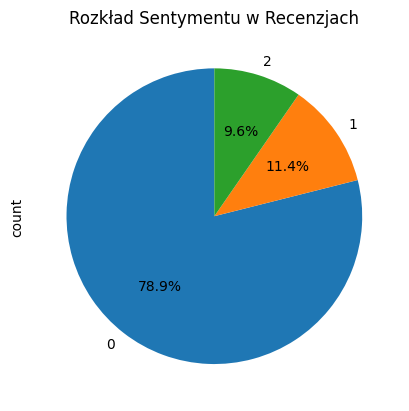

In [49]:
import matplotlib.pyplot as plt

# Analiza liczby recenzji w poszczególnych kategoriach sentymentu
sentiment_distribution = df["Etykieta_Sentymentu"].value_counts()

# Wykres kołowy
sentiment_distribution.plot(kind="pie", autopct="%1.1f%%", startangle=90)
plt.title("Rozkład Sentymentu w Recenzjach")
plt.show()

#  NLTK

In [50]:
from nltk.sentiment import SentimentIntensityAnalyzer

In [51]:
def analyze_sentiment_nltk(text):
    sia = SentimentIntensityAnalyzer()
    sentiment_score = sia.polarity_scores(text)["compound"]
    return sentiment_score

In [52]:
df["Sentyment_NLTK"] = df["tokenized_reviews"].apply(analyze_sentiment_nltk)

In [53]:
def label_sentiment(score):
    if score >= 0.05:
        return 2 #'Pozytywny'
    elif score <= -0.05:
        return 1 #'Negatywny'
    else:
        return 0 #'Neutralny'

df["Etykieta_Sentymentu_NLTK"] = df["Sentyment_NLTK"].apply(label_sentiment)

In [54]:
df["Etykieta_Sentymentu_NLTK"].value_counts()

Etykieta_Sentymentu_NLTK
1    2183
0    2074
2    1705
Name: count, dtype: int64

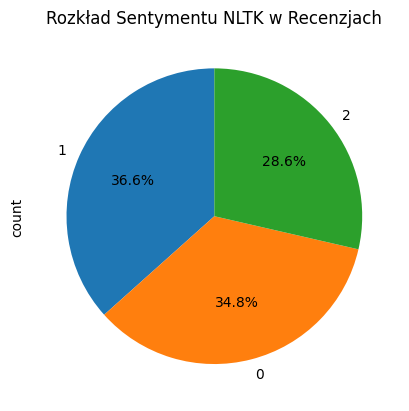

In [55]:
# Analiza liczby recenzji w poszczególnych kategoriach sentymentu
sentiment_distribution = df["Etykieta_Sentymentu_NLTK"].value_counts()

# Wykres kołowy
sentiment_distribution.plot(kind="pie", autopct="%1.1f%%", startangle=90)
plt.title("Rozkład Sentymentu NLTK w Recenzjach")
plt.show()

In [ ]:
#Do modeli wykorzystam Etykieta_Sentymentu_NLTK
# Zaczne od lasów losowych

In [56]:
df.columns


Index(['Unnamed: 0', 'Link', 'Autor', 'Tytuł', 'Data_recenzji',
       'Treść_recenzji', 'Średnia_ocen', 'Liczba_ocen', 'Liczba_czytelników',
       'Rok_recenzji', 'language_reviews', 'tokenized_reviews', 'Sentyment',
       'Etykieta_Sentymentu', 'Sentyment_NLTK', 'Etykieta_Sentymentu_NLTK'],
      dtype='object')

In [57]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE

In [58]:
# Przygotowuję zbiory: treningowy, walidacyjny i testowy
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=42)

In [59]:
# Tworzę macierz TF-IDF
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train = vectorizer.fit_transform(train_data["tokenized_reviews"])
X_val = vectorizer.transform(val_data["tokenized_reviews"])
X_test = vectorizer.transform(test_data["tokenized_reviews"])

In [60]:
# Etykiety
y_train = train_data["Etykieta_Sentymentu_NLTK"]
y_val = val_data["Etykieta_Sentymentu_NLTK"]
y_test = test_data["Etykieta_Sentymentu_NLTK"]

In [61]:
# Podejście 1 - model RandomForestClassifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [62]:
# Teraz będę oceniać modelu bazowego na zestawie walidacyjnym
y_val_pred = rf_model.predict(X_val)
print("Raport dla RandomForestClassifier na zestawie walidacyjnym:\n", classification_report(y_val, y_val_pred))

Raport dla RandomForestClassifier na zestawie walidacyjnym:
               precision    recall  f1-score   support

           0       0.78      0.94      0.85       409
           1       0.87      0.86      0.86       438
           2       0.87      0.67      0.76       346

    accuracy                           0.83      1193
   macro avg       0.84      0.82      0.82      1193
weighted avg       0.84      0.83      0.83      1193



In [63]:
# Teraz będę oceniać modelu bazowego na zestawie testowym
y_test_pred = rf_model.predict(X_test)
print("Raport dla RandomForestClassifier na zestawie testowym:\n", classification_report(y_test, y_test_pred))

Raport dla RandomForestClassifier na zestawie testowym:
               precision    recall  f1-score   support

           0       0.72      0.91      0.81       390
           1       0.84      0.81      0.83       455
           2       0.86      0.65      0.74       348

    accuracy                           0.80      1193
   macro avg       0.81      0.79      0.79      1193
weighted avg       0.81      0.80      0.79      1193



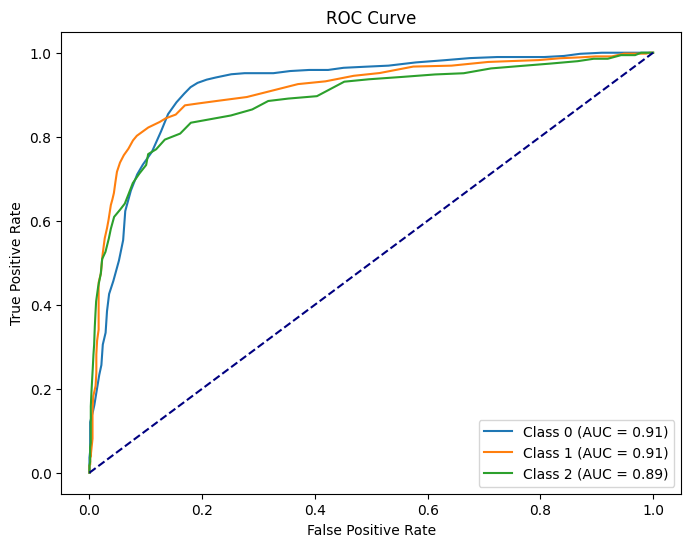

In [64]:
# Krzywa ROC
from sklearn.metrics import roc_curve, auc

# Prawdopodobieństwa przewidywane przez model dla zbioru testowego
y_probs = rf_model.predict_proba(X_test)
classes = [0, 1, 2]
# Krzywa ROC dla każdej klasy
plt.figure(figsize=(8, 6))
for i in range(len(classes)):
    fpr, tpr, _ = roc_curve(y_test == classes[i], y_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {classes[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [ ]:
# Model XGBoost

In [65]:
import xgboost as xgb
from sklearn.metrics import accuracy_score

In [66]:
# Utworzenie i trening modelu XGBoost
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [67]:
# Ocena modelu na danych walidacyjnych
y_val_pred_xgb = xgb_model.predict(X_val)
print("Classification Report XGBoost:")
print("Raport dla XGBoostna zestawie walidacyjnym:\n", classification_report(y_val, y_val_pred_xgb))

Classification Report XGBoost:
Raport dla XGBoostna zestawie walidacyjnym:
               precision    recall  f1-score   support

           0       0.84      0.97      0.90       409
           1       0.91      0.90      0.90       438
           2       0.92      0.77      0.83       346

    accuracy                           0.88      1193
   macro avg       0.89      0.88      0.88      1193
weighted avg       0.89      0.88      0.88      1193



In [68]:
# Ocena modelu na danych testowych
y_test_pred_xgb = xgb_model.predict(X_test)
print("Raport dla XGBoostna zestawie testowym:\n", classification_report(y_test, y_test_pred_xgb))

Raport dla XGBoostna zestawie testowym:
               precision    recall  f1-score   support

           0       0.80      0.97      0.87       390
           1       0.89      0.85      0.87       455
           2       0.93      0.75      0.83       348

    accuracy                           0.86      1193
   macro avg       0.87      0.86      0.86      1193
weighted avg       0.87      0.86      0.86      1193



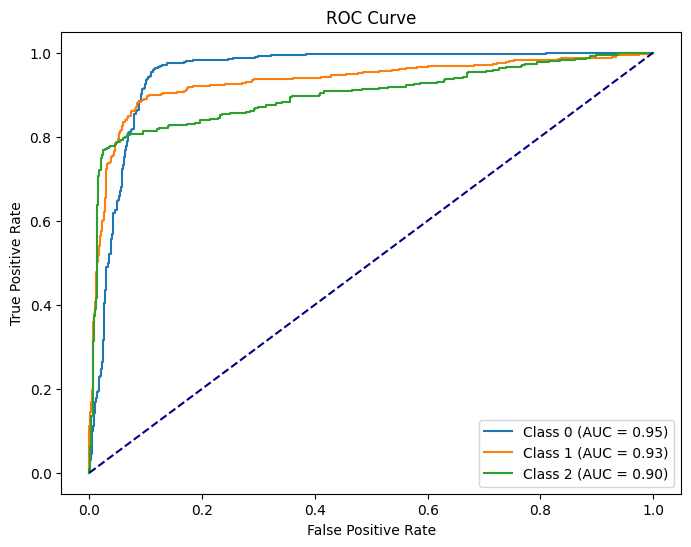

In [69]:
# Krzywa ROC
from sklearn.metrics import roc_curve, auc

# Prawdopodobieństwa przewidywane przez model dla zbioru testowego
y_probs = xgb_model.predict_proba(X_test)

# Krzywa ROC dla każdej klasy
plt.figure(figsize=(8, 6))
for i in range(len(classes)):
    fpr, tpr, _ = roc_curve(y_test == classes[i], y_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {classes[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()